<a href="https://colab.research.google.com/github/aayushhiii/Customer_360_Analysis/blob/main/Copy_of_Ayushi_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
customers 360 degree analysis

1) hard data and soft data
focus on soft data for prediction

2) predicting customers behaviour
churn analysis,sentiment, propensity to buy,lifetime value

3) predicting strategies to improve sale
(focusing on purchase history , offering discounts, demonstrating increased dissatisfaction or any negative reviews(causes of churn))

4) Identifying relationship ,connections with company and predicting flags (churn , fraud risk)

5)https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_order_reviews_dataset.csv

6) https://github.com/mapr-demos/customer360

7) https://www.kaggle.com/blastchar/telco-customer-churn

8) https://www.kaggle.com/vijayuv/onlineretail ( only tracking essential metrics, customer segmentation, and predicting the lifetime value 
                                                  possible in this dataset)

9) https://blog.hootsuite.com/buyer-persona/ (basic approach to create buyers persona)

10) if we have the transactional records dataset we can break down to clustering customers and then based on transaction
  clusters can be predicted accordingly and recommendations can be provided to win back customers.
  ( https://archive.ics.uci.edu/ml/datasets/online+retail#) can be done on this retail dataset.

11) Customer Segmentation (k-means)
Determine appropriate product pricing.
Develop customized marketing campaigns.
Design an optimal distribution strategy.
Choose specific product features for deployment.
Prioritize new product development efforts.

12) https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python (demographic data)

13) https://www.kaggle.com/carrie1/ecommerce-data ,https://www.kaggle.com/snap/amazon-fine-food-reviews (Combining these two datasets I think 
I can predict the next item that can be recommended to customers and recommend startegies  to run personalized, high-performing campaigns by 
segmenting customers based on their past transactions and history)

14) dataset columns required

    user ID , Product ID , Ratings, invoice date , amount spend by customer, invoice number


'''


# **Customer 360 Analysis**

### *   Product Recommendation

### *   RFM Analysis

### *   Offer Prediction

### *   CLV Analysis
















###***Importing the Dataset***

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data1.csv to data1.csv


###***Importing Libraries and Preprocessing***

In [ ]:
import numpy as np 
import pandas as pd

In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['data1.csv']), header= 0,
                        encoding= 'unicode_escape')


In [ ]:
df['Rating'] = np.random.randint(1, 6, df.shape[0]) #creating column rating with random values 1 to 5

#The used_discount , used_bogo and Offer in dataframe are on Products  

df["used_discount"]=np.random.randint(0,2,df.shape[0]) #creating discount column with random values 0 and 1
df["used_bogo"]=np.where(df["used_discount"]==1,0,1) #creating bogo column where 1 put 0 in discount and vice versa
off=['Buy one get one','No offer','10','15','20','25'] #offer column
df["Offer"]=np.random.choice(off,size=len(df))
df



In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df["Day_Name"] = pd.to_datetime(df["InvoiceDate"]).dt.day_name()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Rating,used_discount,used_bogo,Offer,Day_Name
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,3,0,1,Buy one get one,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,1,0,15,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2,1,0,20,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,5,1,0,20,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,3,1,0,Buy one get one,Wednesday


In [ ]:
df.shape

(541909, 13)

In [ ]:
df.info()

In [ ]:
round(100*(df.isnull().sum())/len(df), 2) #finding null values

In [ ]:
df.dropna(inplace=True) #dropping null values

In [ ]:
round(100*(df.isnull().sum())/len(df), 2) # no null values found now

In [ ]:
df.shape

(406829, 13)

In [ ]:
df['CustomerID'] = df['CustomerID'].astype('int')
df['Rating'] = df['Rating'].astype('int')
df['Quantity'] = df['Quantity'].astype('int')
df['UnitPrice'] = df['UnitPrice'].astype('float')
df.info()

##***Product Recommendation***

###Importing Libraries 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS

In [ ]:
df.shape

(406829, 13)

In [ ]:
# grouping data customer wise (counting and finding the mean)
count = df.groupby("CustomerID", as_index=False).count() 
mean = df.groupby("CustomerID", as_index=False).mean()

In [ ]:
df1 = pd.merge(df, count, how='right', on=["CustomerID"]) #Merging df and count dataframe


In [ ]:
df1["Count"] = df1["StockCode_y"]
df1["Rating"] = df1["Rating_x"]
df1["Description"] = df1["Description_x"]


df1 = df1[["CustomerID",'Description','Rating',"Count"]]

In [ ]:
df1 = df1.sort_values('Count', ascending=False)
df2 = df1[df1.Count >= 100] #considering customers only for those we have data more than 100
df4 = df.groupby("CustomerID", as_index=False).mean()

In [ ]:
#Dataframe of only Description of total products purchased by Customers
combine_summary = df2.groupby("CustomerID")["Description"].apply(list) 
combine_summary = pd.DataFrame(combine_summary)
combine_summary.to_csv("combine_summary.csv")
combine_summary

In [ ]:
df3 = pd.read_csv("combine_summary.csv")
df3 = pd.merge(df3, df4, on="CustomerID", how='inner')
df3 = df3[['CustomerID','Description','Rating']]

In [ ]:
#Function for cleaning up the Description
cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#Cleaning the Description by calling the function
df3["Description_clean"] = df3["Description"].apply(cleanup)

In [ ]:
df3 = df3.drop_duplicates(['Rating'], keep='last')
df3 = df3.reset_index()

In [ ]:
#CountVectorizer that tokenize a collection of text in description of Products
from pandas import DataFrame 
from sklearn.feature_extraction.text import CountVectorizer 
docs = df3["Description_clean"] 
vect = CountVectorizer(max_features = 100, stop_words='english') 
X = vect.fit_transform(docs) 

df5 = DataFrame(X.A, columns=vect.get_feature_names())
df5 = df5.astype(int)

In [ ]:
df5.to_csv("df5.csv")
kkk=df.sort_values(by='Rating', ascending=False)
kkk  = df.drop_duplicates(['Description'], keep='first') #Keeping the best rating product by arranging in descending order
kkk = kkk.reset_index()

In [ ]:
#splitting test and train size for k-nearest neighnour
X = np.array(df5)

tpercent = 0.95
tsize = int(np.floor(tpercent * len(df5)))
df5_train = X[:tsize]

df5_test = X[tsize:]

lentrain = len(df5_train)
lentest = len(df5_test)



In [ ]:
#fitting train data to nearest neighbour
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(df5_train)


distances, indices = nbrs.kneighbors(df5_train)
nbrs

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                 radius=1.0)

In [ ]:
#finding out best product recommendation for test data
for i in range(lentest):
    a = nbrs.kneighbors([df5_test[i]])
    related_product_list = a[1]
    
    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    third_related_product = [item[2] for item in related_product_list]
    third_related_product = str(third_related_product).strip('[]')
    third_related_product = int(third_related_product)
    
    print ("Based on  description, for user is ", df3["CustomerID"][lentrain + i])

    for i in range(3896):
      if (kkk["CustomerID"][i] == df3["CustomerID"][first_related_product]):
        print ("The first similar user is ", df3["CustomerID"][first_related_product], ".") 
        print ("He/She likes following products")
        for i in range(3896):
            if (kkk["CustomerID"][i] == df3["CustomerID"][first_related_product]): 
                aaa= kkk["StockCode"][i]
                bbb= kkk["Rating"][i]

                print(aaa ," and it's rating is : ", bbb)
        print ("--------------------------------------------------------------------")
        break
      
        #print("_________")
    for i in range(3896):
      if (kkk["CustomerID"][i] == df3["CustomerID"][second_related_product]):
        print ("The second similar user is ", df3["CustomerID"][second_related_product], ".") 
        print ("He/She likes following products")
        for i in range(3896):
            if (kkk["CustomerID"][i] == df3["CustomerID"][second_related_product]): 
                aaa= kkk["StockCode"][i]
                bbb=kkk["Rating"][i]

                print(aaa ," and it's rating is : ", bbb)
        print ("--------------------------------------------------------------------")
        break

    for i in range(3896):
      if (kkk["CustomerID"][i] == df3["CustomerID"][third_related_product]):
        print ("The third similar user is ", df3["CustomerID"][third_related_product], ".") 
        print ("He/She likes following products")
        for i in range(3896):
            if (kkk["CustomerID"][i] == df3["CustomerID"][third_related_product]): 
                aaa= kkk["StockCode"][i]
                bbb=kkk["Rating"][i]

                print(aaa ," and it's rating is : ", bbb)
        print ("--------------------------------------------------------------------")
        break
      
      

    print ("--------------------------------------------------------------------")

Based on  description, for user is  17961
The first similar user is  15281 .
He/She likes following products
21280  and it's rating is :  3
--------------------------------------------------------------------
The second similar user is  15834 .
He/She likes following products
16248B  and it's rating is :  3
21841  and it's rating is :  3
--------------------------------------------------------------------
--------------------------------------------------------------------
Based on  description, for user is  17964
--------------------------------------------------------------------
Based on  description, for user is  17965
The second similar user is  17419 .
He/She likes following products
21773  and it's rating is :  2
--------------------------------------------------------------------
The third similar user is  14461 .
He/She likes following products
90036F  and it's rating is :  4
90030B  and it's rating is :  1
90131  and it's rating is :  5
84551  and it's rating is :  4
--------

###***Code for Personalized Product Recommendation***

*   Enter Customer Id (eg 17961 , 18041 )

>                 Get the best Products with best Ratings







In [ ]:
#Final code for personalised recommendation

user=int(input("enter Customer ID for recommendation : "))

a=df3.loc[df3['CustomerID'] == user]
b=df3[df3['CustomerID']==user].index.values
b= str(b).strip('[]')
b= int(b)
c=df5.loc[[b]]

X = np.array(c)

a = nbrs.kneighbors(c)
related_product_list = a[1]

first_related_product = [item[0] for item in related_product_list]
first_related_product = str(first_related_product).strip('[]')
first_related_product = int(first_related_product)
second_related_product = [item[1] for item in related_product_list]
second_related_product = str(second_related_product).strip('[]')
second_related_product = int(second_related_product)
third_related_product = [item[2] for item in related_product_list]
third_related_product = str(third_related_product).strip('[]')
third_related_product = int(third_related_product)

print ("Based on  description, for user is ", user)

for i in range(3896):
  if (kkk["CustomerID"][i] == df3["CustomerID"][first_related_product]):
    print ("The first similar user is ", df3["CustomerID"][first_related_product], ".") 
    print ("He/She likes following products")
    for i in range(3896):
        if (kkk["CustomerID"][i] == df3["CustomerID"][first_related_product]): 
            aaa= kkk["StockCode"][i]
            bbb=kkk["Rating"][i]

            print(aaa ," and it's rating is : ", bbb)
    print ("--------------------------------------------------------------------")
    break

for i in range(3896):
  if (kkk["CustomerID"][i] == df3["CustomerID"][second_related_product]):
    print ("The second similar user is ", df3["CustomerID"][second_related_product], ".") 
    print ("He/She likes following products")
    for i in range(3896):
        if (kkk["CustomerID"][i] == df3["CustomerID"][second_related_product]): 
            aaa= kkk["StockCode"][i]
            bbb=kkk["Rating"][i]

            print(aaa ," and it's rating is : ", bbb)
    print ("--------------------------------------------------------------------")
    break

for i in range(3896):
  if (kkk["CustomerID"][i] == df3["CustomerID"][third_related_product]):
    print ("The third similar user is ", df3["CustomerID"][third_related_product], ".") 
    print ("He/She likes following products")
    for i in range(3896):
        if (kkk["CustomerID"][i] == df3["CustomerID"][third_related_product]): 
            aaa= kkk["StockCode"][i]
            bbb=kkk["Rating"][i]

            print(aaa ," and it's rating is : ", bbb)
    print ("--------------------------------------------------------------------")
    break
      
      

print ("--------------------------------------------------------------------")




enter Customer ID for recommendation : 18041
Based on  description, for user is  18041
The first similar user is  12720 .
He/She likes following products
22346  and it's rating is :  5
22344  and it's rating is :  3
22345  and it's rating is :  5
--------------------------------------------------------------------
The second similar user is  12683 .
He/She likes following products
23348  and it's rating is :  5
--------------------------------------------------------------------
The third similar user is  16873 .
He/She likes following products
85230E  and it's rating is :  4
22826  and it's rating is :  1
22852  and it's rating is :  3
--------------------------------------------------------------------
--------------------------------------------------------------------


###**RFM Analysis**

###importing required libraries for clustering

In [ ]:
# RFM Analysis

# imported required libraries for clustering

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [ ]:
df.shape

(406829, 13)

In [ ]:
df.describe()

In [ ]:
df['CustomerID'] = df['CustomerID'].astype(str)

###Monetary

In [ ]:
#  Monetary

df['Amount'] = df['Quantity']*df['UnitPrice'] #creating amount column multiplying Quantity to Price

In [ ]:
rfm_m = df.groupby('CustomerID')['Amount'].sum() #Summing up the total amount spent by customer
rfm_m = rfm_m.reset_index()

###Frequency

In [ ]:
#  Frequency
rfm_f = df.groupby('CustomerID')['InvoiceNo'].count() #counting no. of purchases made by customers
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

In [ ]:
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

###Recency

In [ ]:
#  Recency
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')
df.head()

In [ ]:
# we get the latest date
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [ ]:
#diff between latest date and invoice date in days
df['Diff'] = max_date - df['InvoiceDate']
df.head()

In [ ]:
# last transaction date to get the recency of customers

rfm_p = df.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

In [ ]:
# taking no. of days only
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

Final RFM Dataset

In [ ]:
# final rfm dataset
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346,0.00,2,325
1,12347,4310.00,182,1
2,12348,1797.24,31,74
3,12349,1757.55,73,18
4,12350,334.40,17,309


Text(0.5, 0, 'Attributes')

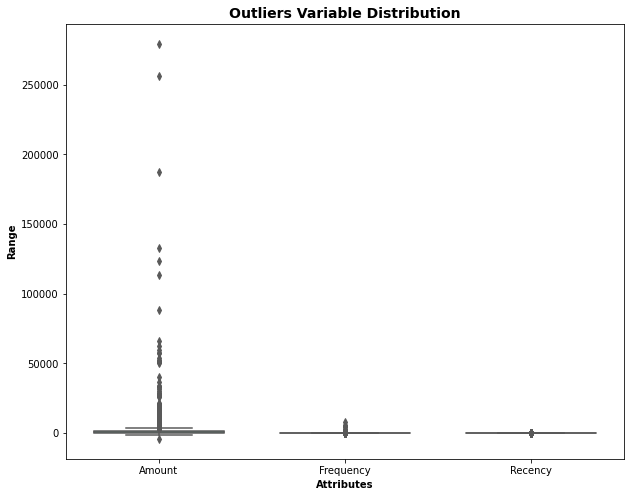

In [ ]:
#Detecting outlier

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
# Removing outliers for Amount

Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]
rfm

In [ ]:
# Removing outliers for Recency

Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]
rfm

In [ ]:
# Removing outliers for Frequency

Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]
rfm

In [ ]:
# Rescaling 
#Using standard Scaler to fit Transform

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [ ]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

K-means Clustering to determine optimum number of Clusters

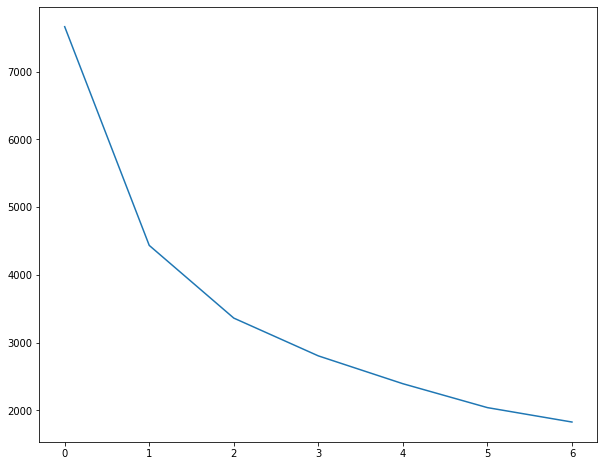

In [ ]:
# k means clustering
# Elbow-curve

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot for each n_clusters
plt.plot(ssd)

Final Model with K=3

In [ ]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
 kmeans.labels_

array([0, 1, 2, ..., 0, 2, 2], dtype=int32)

In [ ]:
rfm['Cluster_Id'] = kmeans.labels_
rfm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346,0.00,2,325,0
1,12347,4310.00,182,1,1
2,12348,1797.24,31,74,2
3,12349,1757.55,73,18,2
4,12350,334.40,17,309,0
...,...,...,...,...,...
4366,18278,173.90,9,73,2
4367,18280,180.60,10,277,0
4368,18281,80.82,7,180,0
4369,18282,176.60,13,7,2


Box plot to visualize Cluster Id vs Monetary

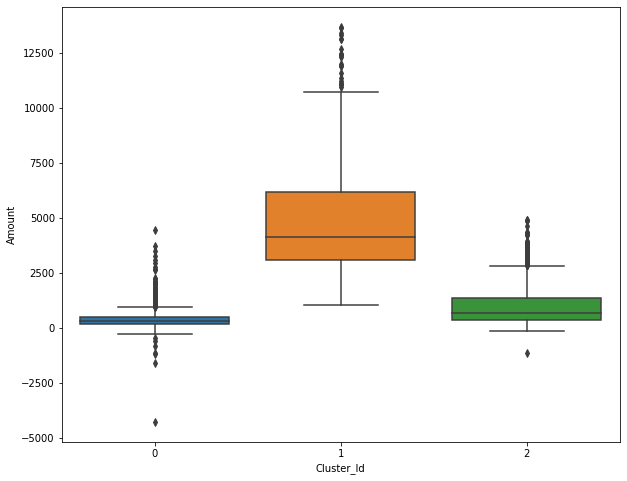

In [ ]:
# Box plot to visualize Cluster Id vs Monetary

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

Box plot to visualize Cluster Id vs Recency

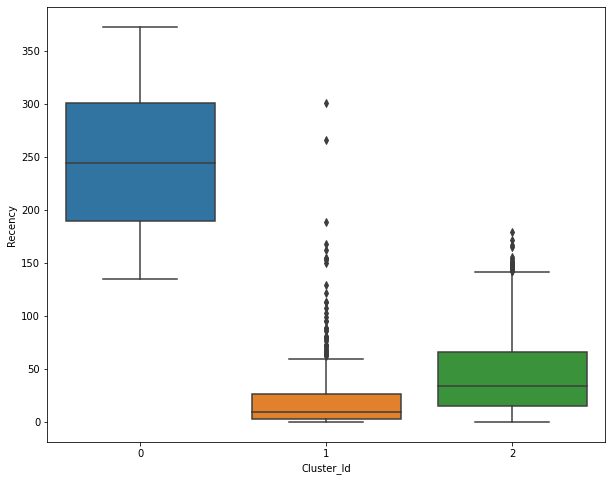

In [ ]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

Box plot to visualize Cluster Id vs Frequency

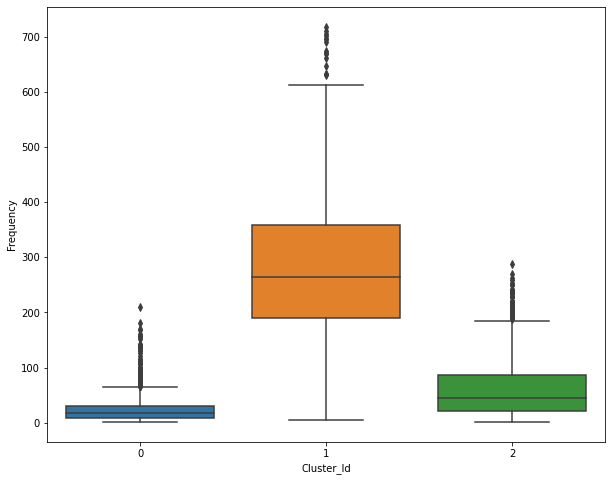

In [ ]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

###Result RFM

* cluster id 0= Low monetary , High recency , Low frequency

  These Customers have not purchased for a long time , they need to be    Provided with some Good Offers and advertisements.

* cluster id 1= High monetary , Low recency , High freqency 

  They are the new Customers who are making Good purchases , keep them engaged with ongoing Offers.

* cluster id 2= Moderate monetary , Moderate recency , Moderate frequency 

  These customers are neither making any major profit or loss to the company .
Try to increase their purchases by providing better offers and keep them engaged.




###***Personalised RFM analysis***

###Enter Customer Id ( eg 12347 , 12348 )

In [ ]:
customer=input("enter customer id = ")

d=rfm.loc[rfm['CustomerID'] == customer,'Cluster_Id'].iloc[0]
d
if (d==0):
  print("This Customer belongs to cluster ID =",d,"which has low monetary, high recency , low frequency")
  print("*******************************************************************")
  print("These Customers have not purchased for a long time , they need to be Provided with some Good Offers and advertisements.")
  print("*******************************************************************")
elif (d==1):
  print("This Customer belongs to Cluster ID =", d, "which has High monetary, low recency , High frequency")
  print("*******************************************************************")
  print("They are the new Customers who are making Good purchases , keep them engaged with ongoing Offers.")
  print("*******************************************************************")

else:
  print("This Customer belongs to Cluster ID =",d,"which has Moderate monetary, Moderate recency , Moderate frequency")
  print("*******************************************************************")
  print("These customers are neither making any major profit or loss to the company . Try to increase their purchases by providing better offers and keep them engaged")
  print("*******************************************************************")


enter customer id = 12347
This Customer belongs to Cluster ID = 1 which has High monetary, low recency , High frequency
*******************************************************************
They are the new Customers who are making Good purchases , keep them engaged with ongoing Offers.
*******************************************************************


###***Offer Prediction***
Predicting Next offer on product that is to be displayed so that it get purchased

In [ ]:
nums = {"Offer": {"No offer": 1, "Buy one get one": 2, "10": 3, "15": 4,
                                  "20": 5, "25": 6}}  #encoding offers so that we can train in linear regression
df['Offer'] = df['Offer'].astype(str)

In [ ]:
df = df.replace(nums)
df

In [ ]:
df6 = df.copy(deep=True)

In [ ]:
#label encoding Stock Code
from sklearn.preprocessing import LabelEncoder
  
le = LabelEncoder()
  
df6["StockCode"]= le.fit_transform(df6['StockCode'])

df6


In [ ]:
#determining X and Y for train and predict

x = df6[['StockCode','used_discount', 'used_bogo','UnitPrice']]
y=df6['Offer']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#splitting the size
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

Using Linear regression for prediction

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [ ]:
#fitting the model
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
predictions = model.predict(x_test)

###**Personalised code for offer prediction of Product**

Enter Stock Code (eg 23225)

Enter Unit price of that Product  ( eg 673)

Enter whether discount used earlier on this Product ( 1 or 0 )

Enter whether BOGO used earlier on this Product ( 1 or 0 )


In [ ]:
# final code for offer

StockCode=input("enter stock code  ")
price=float(input("enter unit price of item "  ))
used_discount=int(input("enter whether discount used earlier on this item (0 (No) , 1 (Yes) )  "))
used_bogo=int(input("enter whether bogo used earlier on this item (0 (No) , 1 (Yes) ))  "))

b=df[df['StockCode']==StockCode].index.values
b=b[0]
b= str(b).strip('[]')
b= int(b)

c=df6[df6.index==b]
f=(c['StockCode']).to_string(index=False)
p= str(f).strip(' ')
p= int(p)

new_input = np.array([[p,used_discount,used_bogo,price]]) # 2D numpy array

new_output = model.predict(new_input)
v = [round(num) for num in new_output]
#print(new_input,v)
v=str(v).strip('[]')
v=int(v)
#v
print("************************************")
if (v==1):
  print("No Offer needed")
elif(v==2):
  print("Provide Buy 1 Get 1")
elif(v==3):
  print("Provide 10% Discount")
elif(v==4):
  print("Provide 15% Discount")
elif(v==5):
  print("Provide 20% Discount")
else:
  print("Provide 25% Discount")
print("************************************")


enter stock code  23225
enter unit price of item 673
enter whether discount used earlier on this item (0 (No) , 1 (Yes) )  1
enter whether bogo used earlier on this item (0 (No) , 1 (Yes) ))  0
************************************
Provide 15% Discount
************************************


###***Customer Lifetime Value***

In [ ]:
df.shape

(406829, 15)

In [ ]:
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice']
data_clv = df[features]

#Determining Total Sales
data_clv['TotalSales'] = data_clv['Quantity'].multiply(data_clv['UnitPrice'])
print(data_clv.shape)
data_clv.head()

(406829, 6)


,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,TotalSales
0,17850,536365,2010-12-01 08:26:00,6,2.55,15.30
1,17850,536365,2010-12-01 08:26:00,6,3.39,20.34
2,17850,536365,2010-12-01 08:26:00,8,2.75,22.00
3,17850,536365,2010-12-01 08:26:00,6,3.39,20.34
4,17850,536365,2010-12-01 08:26:00,6,3.39,20.34


In [ ]:
data_clv.describe()

In [ ]:
data_clv = data_clv[data_clv['TotalSales'] > 0]
data_clv.describe()

In [ ]:
#Finding null values
pd.DataFrame(zip(data_clv.isnull().sum(), data_clv.isnull().sum()/len(data_clv)), columns=['Count', 'Proportion'], index=data_clv.columns)

In [ ]:
# Dropping the null values in the CustomerID variable

data_clv = data_clv[pd.notnull(data_clv['CustomerID'])]
pd.DataFrame(zip(data_clv.isnull().sum(), data_clv.isnull().sum()/len(data_clv)), columns=['Count', 'Proportion'], index=data_clv.columns)

In [ ]:
maxdate = data_clv['InvoiceDate'].dt.date.max()
mindate = data_clv['InvoiceDate'].dt.date.min()
unique_cust = data_clv['CustomerID'].nunique()
tot_quantity = data_clv['Quantity'].sum()
tot_sales = data_clv['TotalSales'].sum()

print(f"The Time range of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")
print(f"Total Quantity Sold: {tot_quantity}")
print(f"Total Sales for the period: {tot_sales}")

The Time range of transactions is: 2010-12-01 to 2011-12-09
Total number of unique customers: 4338
Total Quantity Sold: 5167812
Total Sales for the period: 8911407.904


In [ ]:
Profit_margin = 0.05 

# Transforming the data to customer level for the analysis
customer = data_clv.groupby('CustomerID').agg({'InvoiceDate':lambda x: x.min().month, 
                                                   'InvoiceNo': lambda x: len(x),
                                                  'TotalSales': lambda x: np.sum(x)})

customer.columns = ['Start_Month', 'Frequency', 'TotalSales']
customer.head()

In [ ]:
# Calculating CLV for each cohort

months = ['Jan', 'Feb', 'March', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Monthly_CLV = []

for i in range(1, 13):
    customer_m = customer[customer['Start_Month']==i]
    
    Average_sales = round(np.mean(customer_m['TotalSales']),2)
    
    Purchase_freq = round(np.mean(customer_m['Frequency']), 2)
    
    Retention_rate = customer_m[customer_m['Frequency']>1].shape[0]/customer_m.shape[0]
    churn = round(1 - Retention_rate, 2)
    
    CLV = round(((Average_sales * Purchase_freq/churn)) * Profit_margin, 2)
    
    Monthly_CLV.append(CLV)

***CLV of Customers Month wise***

In [ ]:
monthly_clv = pd.DataFrame(zip(months, Monthly_CLV), columns=['Months', 'CLV'])
display(monthly_clv.style.background_gradient())

,Months,CLV
0,Jan,1546537.090000
1,Feb,313073.920000
2,March,539933.180000
3,Apr,349213.350000
4,May,147597.490000
5,Jun,323795.770000
6,Jul,71760.420000
7,Aug,148834.420000
8,Sep,185155.700000
9,Oct,144042.950000


###***Personalised individual CLV prediction***

In [ ]:
#predictive method
!pip install lifetimes
import lifetimes

In [ ]:
import lifetimes

In [ ]:
summary = lifetimes.utils.summary_data_from_transaction_data(data_clv, 'CustomerID', 'InvoiceDate', 'TotalSales' )
summary = summary.reset_index()
summary.head()

In [ ]:
# Create a distribution of frequency to understand the customer frequence level

summary['frequency'].plot(kind='hist', bins=50)
print(summary['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(summary['frequency'] == 0)/float(len(summary))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

In [ ]:
# Fitting the BG/NBD model

bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 68.91, b: 6.75, r: 0.83>

In [ ]:
# Model summary

bgf.summary

In [ ]:
summary['probability_alive'] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])
summary.head(10)

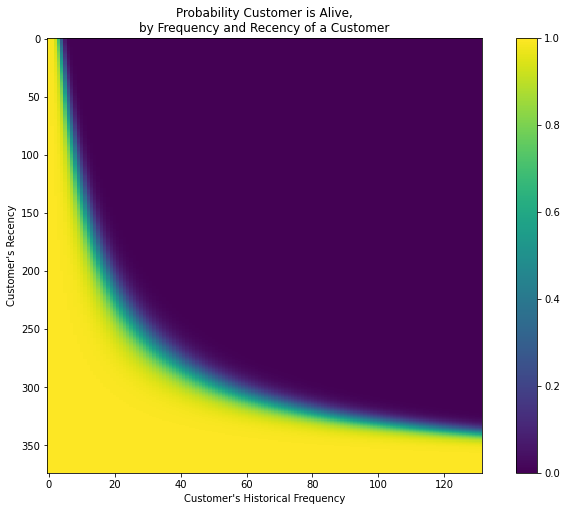

In [ ]:
# Visual representation of relationship between recency and frequency

from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [ ]:
#Predict future transaction for the next 30 days based on historical data

t = 30
summary['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T']),2)
summary.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

In [ ]:
# Checking the relationship between frequency and monetary_value

return_customers_summary = summary[summary['frequency']>0]
print(return_customers_summary.shape)
return_customers_summary.head()

(2790, 7)


,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
1,12347,6.0,365.0,367.0,599.701667,0.999698,0.47
2,12348,3.0,283.0,358.0,301.480000,0.999177,0.27
5,12352,6.0,260.0,296.0,368.256667,0.999406,0.56
9,12356,2.0,303.0,325.0,269.905000,0.999478,0.22
11,12358,1.0,149.0,150.0,683.200000,0.999486,0.25


In [ ]:
# Checking the relationship between frequency and monetary_value

return_customers_summary[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.015906
monetary_value,0.015906,1.000000


In [ ]:
# Modeling the monetary value using Gamma-Gamma Model

ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(return_customers_summary['frequency'],
       return_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 11.13, q: 0.84, v: 11.29>

In [ ]:
ggf.summary

In [ ]:
# Calculating the conditional expected average profit for each customer per transaction

summary = summary[summary['monetary_value'] >0]
summary['exp_avg_sales'] = ggf.conditional_expected_average_profit(summary['frequency'],
                                       summary['monetary_value'])
summary.head()


,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales
1,12347,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247
2,12348,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889
5,12352,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926
9,12356,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534
11,12358,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679


In [ ]:
# Checking the expected average value and the actual average value in the data to make sure the values are good

print(f"Expected Average Sales: {summary['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {summary['monetary_value'].mean()}")

Expected Average Sales: 486.90902215126897
Actual Average Sales: 477.3803385139518


In [ ]:
summary['predicted_clv'] =      ggf.customer_lifetime_value(bgf,
                                                               summary['frequency'],
                                                               summary['recency'],
                                                               summary['T'],
                                                               summary['monetary_value'],
                                                               time=1,     # lifetime in months
                                                               freq='D',   # frequency in which the data is present(T)      
                                                               discount_rate=0.01) # discount rate
summary.head()

In [ ]:
# CLV in terms of profit (profit margin is 5%)

profit_margin = 0.05
summary['CLV'] = summary['predicted_clv'] * profit_margin
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,CLV
1,12347,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247,280.409518,14.020476
2,12348,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889,81.591026,4.079551
5,12352,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926,206.034640,10.301732
9,12356,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534,59.125290,2.956265
11,12358,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679,174.550478,8.727524
